株価データを FFT でフィルター処理（標準化しない場合）

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import make_smoothing_spline

In [2]:
pkl = '../tmp/8035_2024-07-16.pkl'
df0 = pd.read_pickle(pkl)
df0

,Price
2024-07-16 09:00:05,35940.0
2024-07-16 09:00:10,35950.0
2024-07-16 09:00:17,35910.0
2024-07-16 09:00:23,35940.0
2024-07-16 09:00:29,35910.0
...,...
2024-07-16 14:59:39,36050.0
2024-07-16 14:59:45,36050.0
2024-07-16 14:59:52,36060.0
2024-07-16 14:59:59,36080.0


In [3]:
date_str = str(df0.index[0].date())
t1 = pd.to_datetime(date_str + ' 09:00:00')
t2 = pd.to_datetime(date_str + ' 10:00:00')
t_mid = pd.to_datetime(date_str + ' 12:00:00')
t0 = t1.timestamp()
t0

1721120400.0

In [4]:
df1 = df0.loc[df0.index[df0.index < t_mid]]
df1.index = [(t - t1).total_seconds() for t in df1.index]
df1

,Price
5.0,35940.0
10.0,35950.0
17.0,35910.0
23.0,35940.0
29.0,35910.0
...,...
8974.0,35970.0
8985.0,35980.0
8992.0,35980.0
8997.0,35990.0


In [5]:
df2 = df0.loc[df0.index[df0.index > t_mid]]
df2.index = [(t - t2).total_seconds() for t in df2.index]
df2

,Price
9005.0,36010.0
9009.0,36030.0
9017.0,36060.0
9020.0,36050.0
9027.0,36060.0
...,...
17979.0,36050.0
17985.0,36050.0
17992.0,36060.0
17999.0,36080.0


In [6]:
df3 = pd.concat([df1, df2])
dict_data = dict()
n = len(df3)
for idx in range(n):
    series = df3.iloc[idx]
    value = series.iloc[0]
    key = series.name
    dict_data[key] = value

df4 = pd.DataFrame(
    {'Price': dict_data.values()},
    index=list(dict_data.keys())
)

x = np.array([x for x in df4.index])
y = np.array(df4['Price'])
x

array([5.0000e+00, 1.0000e+01, 1.7000e+01, ..., 1.7992e+04, 1.7999e+04,
       1.8000e+04])

In [7]:
spl = make_smoothing_spline(x, y)
xs = np.linspace(x[0], x[len(x) - 1], int((x[len(x) - 1] - x[0]) * 10 + 1))
#xs = np.linspace(x[0], x[len(x) - 1], int(2 ** e))

ys = spl(xs)
xs

array([5.00000e+00, 5.10000e+00, 5.20000e+00, ..., 1.79998e+04,
       1.79999e+04, 1.80000e+04])

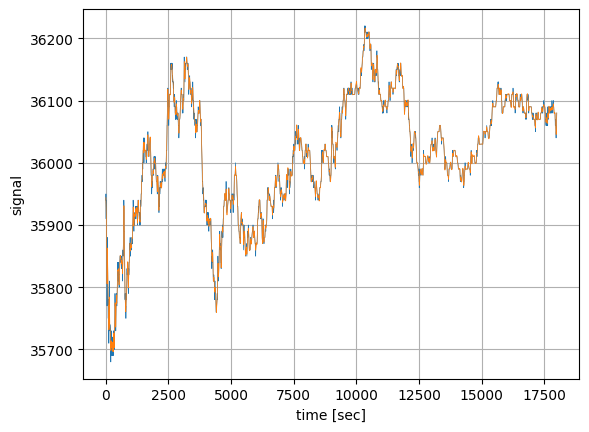

In [8]:
plt.xlabel('time [sec]')
plt.ylabel('signal')
plt.plot(x, y, lw=0.5)
plt.plot(xs, ys, lw=0.5)
plt.grid()
plt.show()

In [9]:
N = len(xs) # サンプル数
dt = 0.1 # サンプリング周期(sec)

In [10]:
# 高速フーリエ変換(FFT)
F = np.fft.fft(ys)

In [11]:
# FFTの複素数結果を絶対値に変換
F_abs = np.abs(F)
# 振幅をもとの信号に揃える
F_abs_amp = F_abs / N * 2 # 交流成分はデータ数で割って2倍
F_abs_amp[0] = F_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要
F_abs

array([6.48054762e+09, 5.72708081e+06, 2.83863729e+06, ...,
       5.68626614e+06, 2.83863729e+06, 5.72708081e+06])

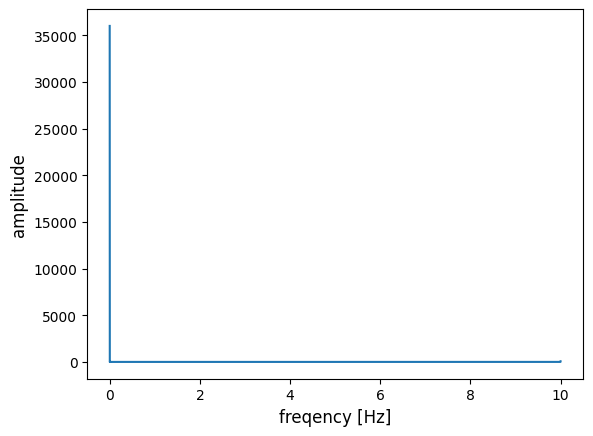

In [12]:
# 周波数軸のデータ作成
fq = np.linspace(0, 1.0/dt, N) # 周波数軸　linspace(開始,終了,分割数)

# グラフ表示（FFT解析結果）
plt.xlabel('freqency [Hz]', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.plot(fq, F_abs_amp)
#plt.xlim(0, 0.0005)
plt.show()

In [13]:
min(F_abs_amp)

np.float64(0.0007566622918000864)

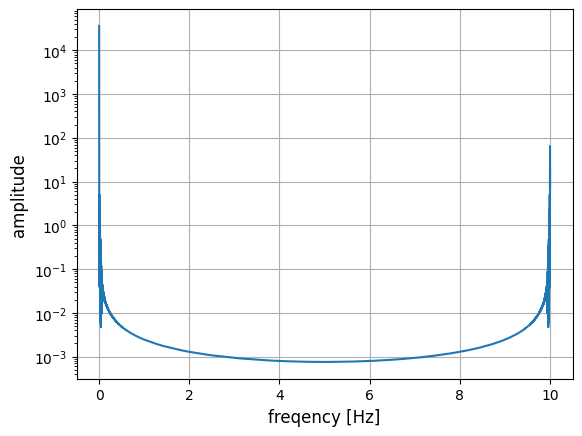

In [14]:
# グラフ表示（FFT解析結果）
plt.xlabel('freqency [Hz]', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.plot(fq, F_abs_amp)
plt.yscale('log')
plt.grid()
plt.show()

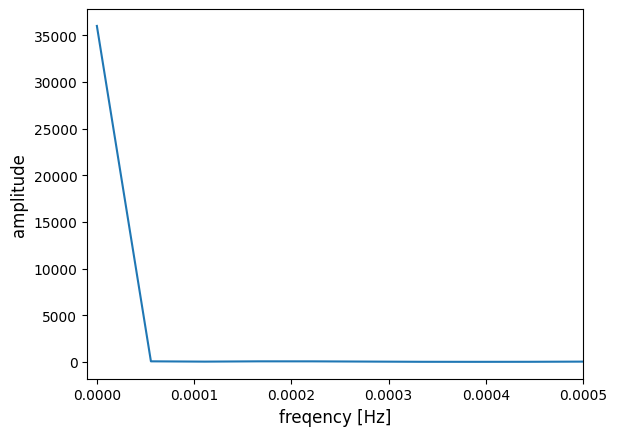

In [15]:
# グラフ表示（FFT解析結果）
plt.xlabel('freqency [Hz]', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.plot(fq, F_abs_amp)
plt.xlim(-0.00001, 0.0005)
plt.show()

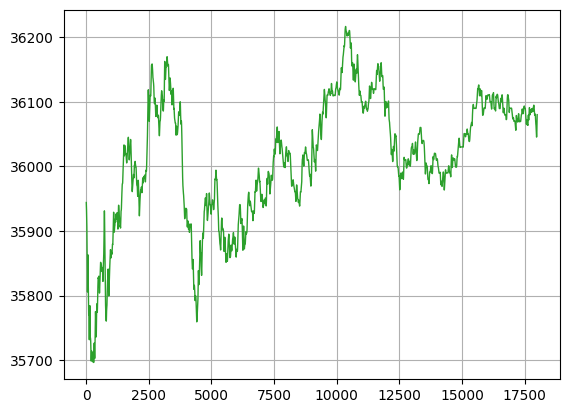

In [16]:
# そのまま普通にIFFTで逆変換した場合
F_ifft = np.fft.ifft(F) # IFFT
F_ifft_real = F_ifft.real # 実数部

plt.plot(xs, F_ifft_real, c='C2', lw=1)
plt.grid()
plt.show()

In [17]:
# 周波数でフィルタリング処理
fc = 0.0025 # カットオフ（周波数）
F2 = np.copy(F) # FFT結果コピー
F2[((fc < fq) & (fq < 10 - fc))] = 0 # カットオフを超える周波数のデータをゼロにする（ノイズ除去）

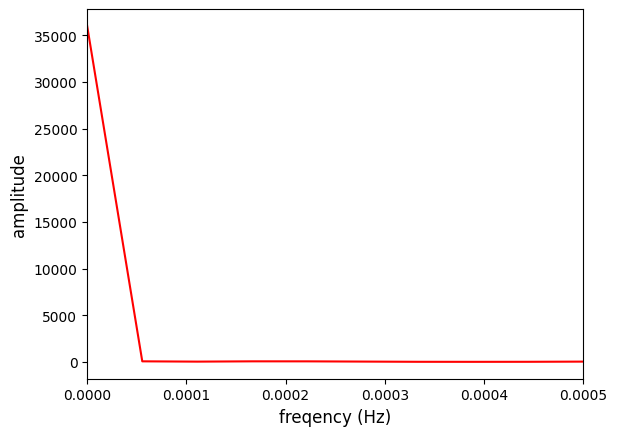

In [18]:
# フィルタリング処理したFFT結果の確認
# FFTの複素数結果を絶対値に変換
F2_abs = np.abs(F2)
# 振幅をもとの信号に揃える
F2_abs_amp = F2_abs / N * 2 # 交流成分はデータ数で割って2倍
F2_abs_amp[0] = F2_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

# グラフ表示（FFT解析結果）
plt.xlabel('freqency (Hz)', fontsize=12)
plt.ylabel('amplitude', fontsize=12)
plt.plot(fq, F2_abs_amp, c='r')
plt.xlim(0, 0.0005)
plt.show()

In [19]:
# 周波数でフィルタリング（ノイズ除去）-> IFFT
F2_ifft = np.fft.ifft(F2) # IFFT

In [20]:
#F2_ifft_real = F2_ifft.real * 2 # 実数部の取得、振幅を元スケールに戻す
F2_ifft_real = F2_ifft.real

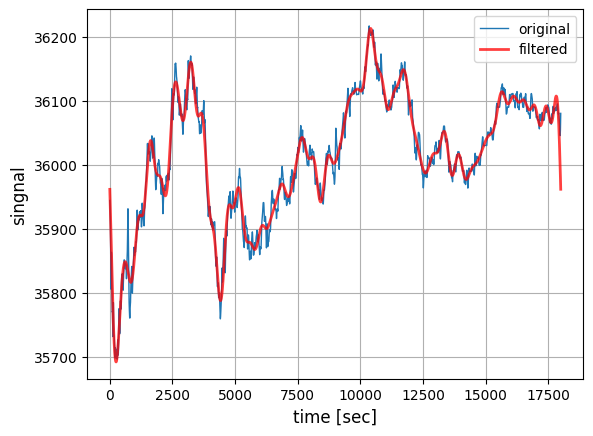

In [21]:
# グラフ表示：オリジナルとフィルタリング（ノイズ除去）
plt.plot(xs, ys, lw=1, c='C0', label='original')
plt.plot(xs, F2_ifft_real, c="red", lw=2, alpha=0.75, label='filtered')
plt.legend(loc='best')
plt.xlabel('time [sec]', fontsize=12)
plt.ylabel('singnal', fontsize=12)
plt.grid()
plt.show()

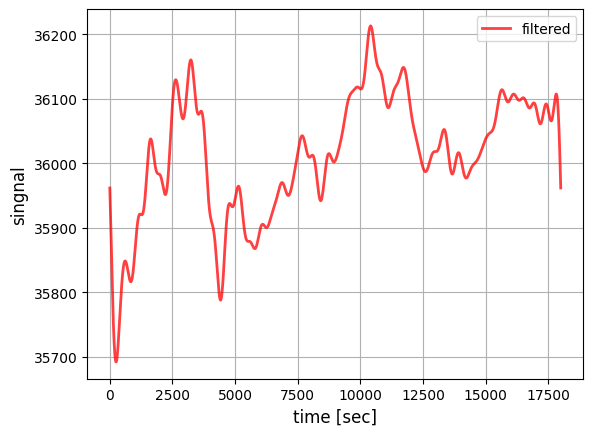

In [22]:
plt.plot(xs, F2_ifft_real, c="red", lw=2, alpha=0.75, label='filtered')
plt.legend(loc='best')
plt.xlabel('time [sec]', fontsize=12)
plt.ylabel('singnal', fontsize=12)
plt.grid()
plt.show()